In [3]:
import tensorflow as tf
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split

# Initialize integrator keywords for solve_ivp to replicate the odeint defaults
integrator_keywords = {}
integrator_keywords['rtol'] = 1e-12
integrator_keywords['method'] = 'LSODA'
integrator_keywords['atol'] = 1e-12

In [2]:
# # from Zhao paper


# def neural_net(self, X, weights, biases): 
#     num_layers = len(weights) + 1
#     H=X
#     for l in range(0, num_layers - 2):
#         W = weights[l]
#         b = biases[l]
#         H = tf.tanh(tf.add(tf.matmul(H, W), b)) 
#     W = weights[-1]
#     b = biases[-1]
#     Y =  tf.add(tf.matmul(H, W), b)
#     return Y

# def net_f(self, u, t):
#     return self.neural_net(tf.concat([u,t],1), self.weights, self.biases)

# def time_march(phi_s1, tau1, tau2, method): 
#     h = tau2 - tau1
#     if method == "Euler": 
#         return phi_s1 + h * net_f(phi_s1, tau1)
#     elif method == "RK2":
#         K1 = net_f(phi_s1, tau1)
#         K2 = net_f(phi_s1 + h/2 * K1, tau1 + h/2)
#         return phi_s1 + h * K2
#     else:
#         return None

# def residual_net(phi1, phi2, t1, t2, method): 
#     phi_s1 = phi1
#     ... # define time steps: tau based on t1,t2.
#     for i in  range(M): 
#         phi_s2 = time_march(phi_s1 , tau[i], tau[i+1], method)
#         phi_s1 = phi_s2
#     return phi2 - phi_s2

done with ivp


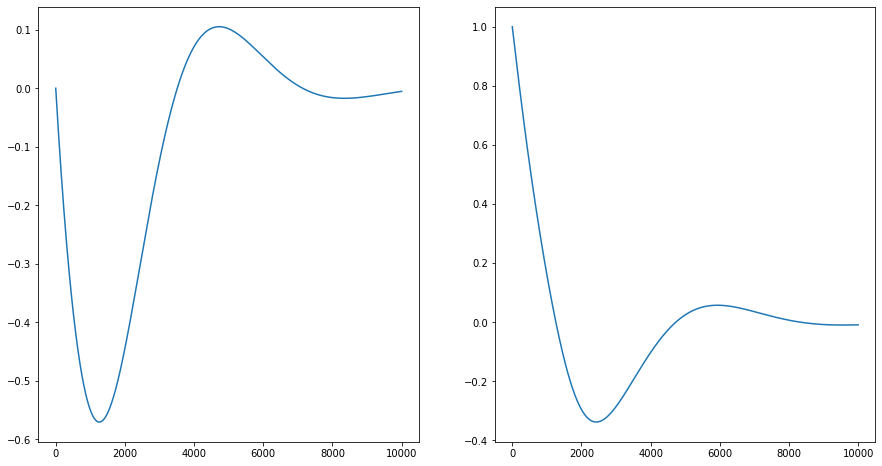

In [110]:
# Generate measurement data
dt = .001

t_train = np.arange(0, 10, dt)
x0_train = [0, 1]
t_train_span = (t_train[0], t_train[-1])
dim = 2
multiple = True

def van_der_pol(t, x, p=[1]):
    return [-x[1],  x[0] - p[0] * (1 - x[0] ** 2) * x[1]]
    
if multiple:
    n_trajectories = 20
    x_train_multi = []
    x0s = np.random.rand(n_trajectories, dim)
    for i in range(n_trajectories):
        x_train_temp = solve_ivp(fun = van_der_pol, t_span=t_train_span, 
                                    y0 = x0s[i], t_eval=t_train, **integrator_keywords).y.T
        x_train_multi.append(x_train_temp)
    print('done with ivp')
x_train = solve_ivp(fun = van_der_pol, t_span = t_train_span, y0 = x0_train, t_eval=t_train, **integrator_keywords).y.T
plt.figure(figsize=(15,8))
plt.subplot(121)
plt.plot(x_train[:,0])
plt.subplot(122)
plt.plot(x_train[:,1])

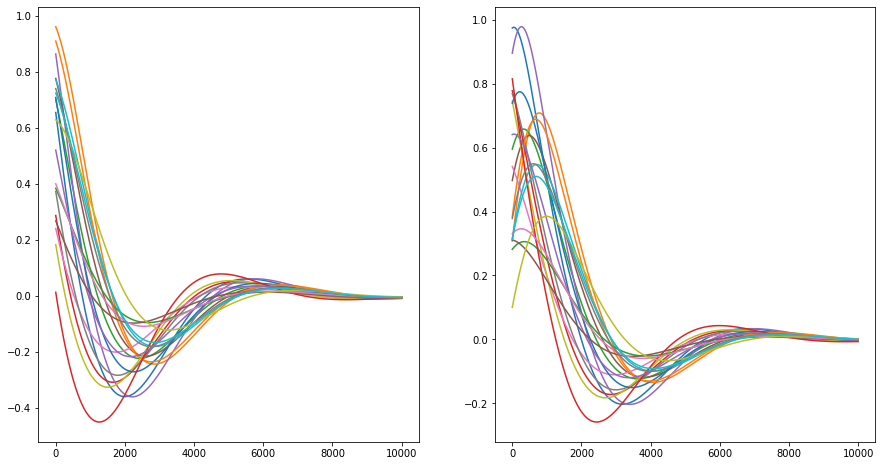

In [111]:
plt.figure(figsize=(15,8))
for i in x_train_multi:
    plt.subplot(121)
    plt.plot(i[:,0])
    plt.subplot(122)
    plt.plot(i[:,1])

In [119]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)
 
# choose a number of time steps
n_steps = 1
# split into samples
X, y = split_sequence(x_train[:,0], n_steps)
print(X.shape, y.shape)

In [ ]:
X = x_train[:,0][0]

In [120]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False) #, random_state=100)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(7999, 1) (2000, 1) (7999,) (2000,)


In [121]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(100, activation='relu', input_dim=n_steps))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(1))
model.compile(optimizer='adam', loss='mse')

In [122]:
history = model.fit(X_train,y_train,validation_data= (X_test, y_test), epochs=20, verbose=1)

Epoch 1/20
250/250 [==============================] - 1s 2ms/step - loss: 0.0016 - accuracy: 0.0000e+00 - val_loss: 1.6549e-09 - val_accuracy: 0.0000e+00
Epoch 2/20
250/250 [==============================] - 0s 1ms/step - loss: 1.5408e-07 - accuracy: 0.0000e+00 - val_loss: 1.8390e-08 - val_accuracy: 0.0000e+00
Epoch 3/20
250/250 [==============================] - 0s 1ms/step - loss: 1.3942e-07 - accuracy: 0.0000e+00 - val_loss: 1.4259e-09 - val_accuracy: 0.0000e+00
Epoch 4/20
250/250 [==============================] - 0s 1ms/step - loss: 1.3203e-07 - accuracy: 0.0000e+00 - val_loss: 1.3622e-08 - val_accuracy: 0.0000e+00
Epoch 5/20
250/250 [==============================] - 0s 1ms/step - loss: 1.4457e-07 - accuracy: 0.0000e+00 - val_loss: 9.1794e-08 - val_accuracy: 0.0000e+00
Epoch 6/20
250/250 [==============================] - 0s 1ms/step - loss: 1.7527e-07 - accuracy: 0.0000e+00 - val_loss: 3.2772e-08 - val_accuracy: 0.0000e+00
Epoch 7/20
250/250 [==============================] - 0s

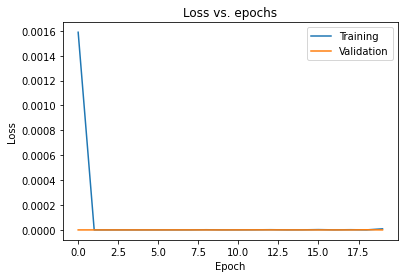

In [123]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

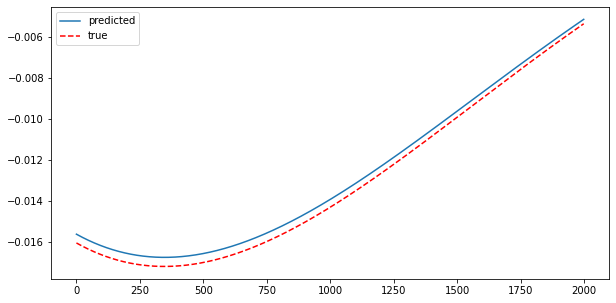

In [128]:
yhat= model.predict(X_test)
plt.figure(figsize=(10,5))
plt.plot(yhat, label = 'predicted')
plt.plot(y_test, 'r--', label = 'true')
plt.legend()

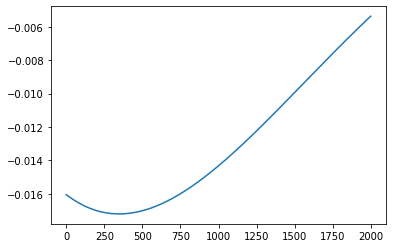

In [125]:
plt.plot(X_test)

In [131]:
X_test.shape

(2000, 1)

In [130]:
y_test

array([-0.01606405, -0.01607101, -0.01607795, ..., -0.00536781,
       -0.00535919, -0.00535058])